In [1]:

from datetime import datetime, timedelta

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import datetime
from tqdm import tqdm
from matplotlib.patches import Rectangle
import warnings

import seaborn as sns

from sklearn import svm
from sklearn.datasets import  make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples

from scipy import stats

warnings.filterwarnings("ignore")



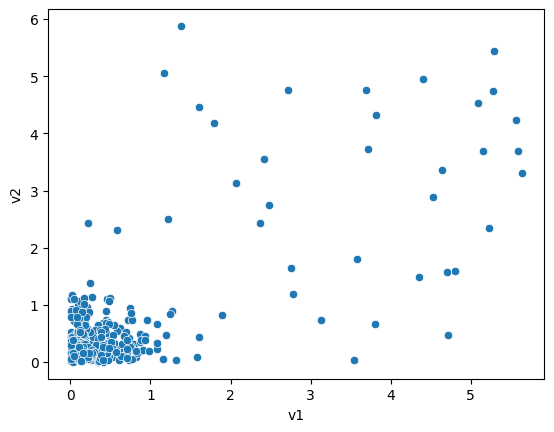

In [4]:
# Example settings
n_samples = 1000
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)

blobs_params = dict(random_state=0, n_samples=n_samples, n_features=2)

X = make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0]

rng = np.random.RandomState(42)
X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

df = pd.DataFrame(X, columns = ['v1', 'v2'])

df = df[df>0]
df.dropna(inplace=True)

sns.scatterplot(
        df,
        x='v1',
        y='v2'
    )
plt.show()

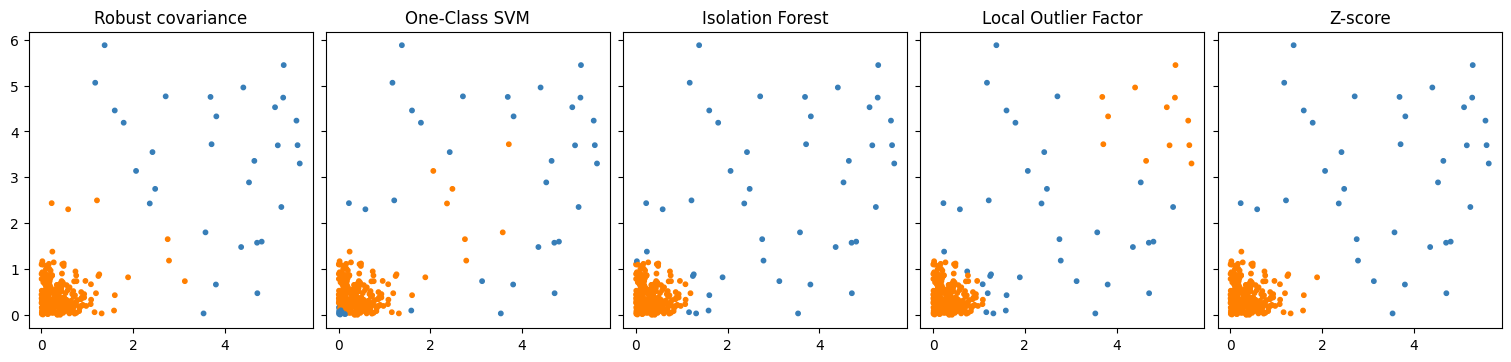

CPU times: user 1.49 s, sys: 153 ms, total: 1.64 s
Wall time: 1.52 s


In [11]:
%%time

# define outlier/anomaly detection methods to be compared
colors = np.array(["#377eb8", "#ff7f00"])

anomaly_algorithms = {
    "Robust covariance": EllipticEnvelope(),
    "One-Class SVM": svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1),
    "Isolation Forest": IsolationForest(random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35),
    "Z-score": stats.zscore
}
algorithm_names = anomaly_algorithms.keys()

th = 1.5
n_features = 2

X = df.iloc[:, :n_features].values

fig, axs = plt.subplots( 1, 5, sharex=True, sharey=True, layout='constrained',  figsize=(15, 15))

i_name = 0
for name, algorithm in anomaly_algorithms.items():
  # fit the data and tag outliers
  if name == "Local Outlier Factor":
    algorithm.fit(X)
    y_pred = algorithm.fit_predict(X)
    y_pred = y_pred == -1
  elif name == "Z-score":
    y_pred = [np.abs(stats.zscore(X[:, i]))>th for i in range(n_features)]
    y_pred
    df_zscore = pd.DataFrame(y_pred).T
    y_pred = df_zscore.any(axis=1).values

  else:
    y_pred = algorithm.fit(X).predict(X)
    y_pred = y_pred == -1
  df[name] = y_pred



  ax= axs[i_name]
  y_pred = df[name]
  y_pred = np.array([0 if i else 1 for i in y_pred])
  ax.set_title(name)
  ax.scatter(df['v1'], df['v2'], s=10, color=colors[y_pred])
  ax.set( aspect='equal')
  i_name += 1
plt.show()

100%|██████████| 2/2 [00:00<00:00, 1002.22it/s]


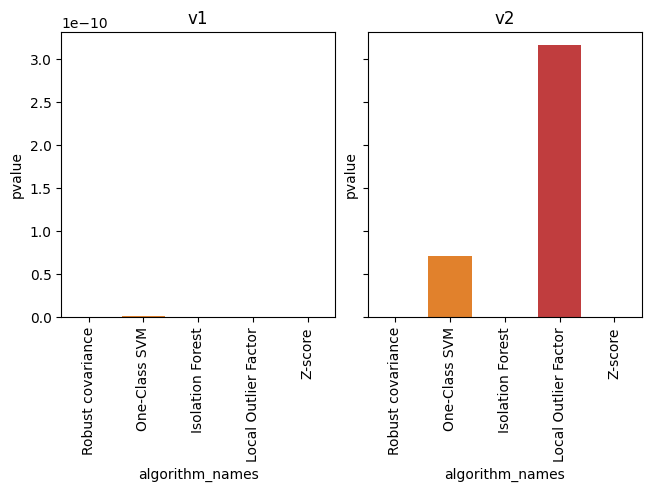

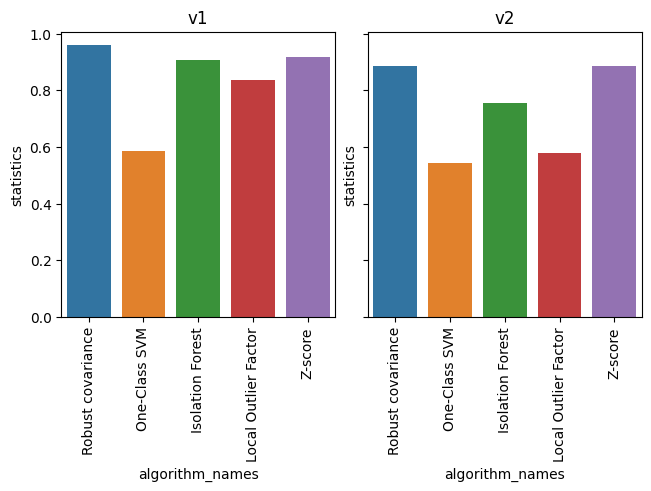

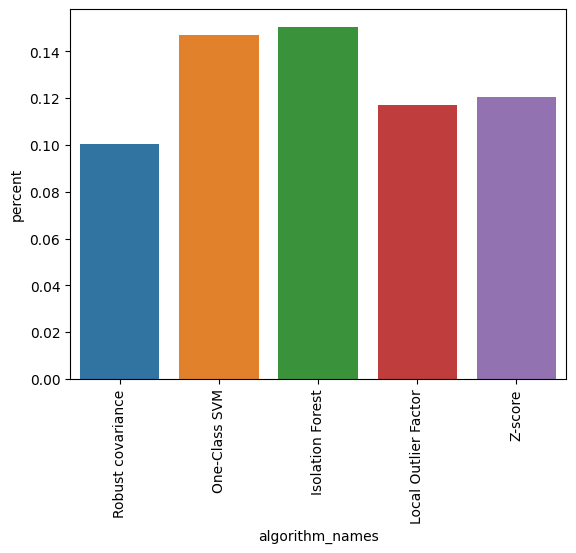

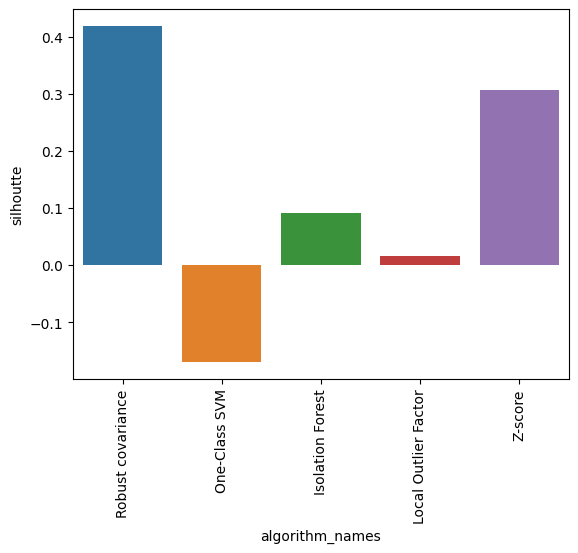

In [12]:
p_values = {}
p_stats_ = {}
percent = {}
silhoutte = {}

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

cols_in = df.columns[:n_features]
for name in algorithm_names:
  #percent anomaly
  dist = df[name].value_counts(normalize=True)
  percent[name] = dist.loc[True]

  #silhouette conficient samples non-anomaly
  labels = [1 if i == True else 2 for i in df[name]]
  df['silhouette_zcore_'+name] = silhouette_samples(X, labels)
  silhoutte[name] = df[df[name]]['silhouette_zcore_'+name].mean()

  #ks coeficient
  normal = df[df[name] == False]
  anomaly = df[df[name] == True]
  for col_in in tqdm(cols_in):
    if len(normal)>0 and len(anomaly)>0:
      stats_, pvalue = stats.kstest(normal[col_in], anomaly[col_in])
      p_values[col_in+'_'+name] = pvalue
      p_stats_[col_in+'_'+name] = stats_

for name, dictionary in {'pvalue': p_values, 'statistics': p_stats_, 'percent': percent, 'silhoutte':silhoutte}.items():
    df_values =  pd.DataFrame([dictionary])
    df_values = df_values.T
    df_values.reset_index(inplace=True)
    df_values.columns = ['algorithm_names', name]
    if name in ['pvalue', 'statistics']:
      df_values[['variable','algorithm_names']] = df_values.algorithm_names.str.split('_', expand=True)
      fig, axs = plt.subplots( 1, 2, sharex=True, sharey=True, layout='constrained')
      for index_col_in, col_in in enumerate(cols_in):
        df_col = df_values[df_values['variable'] == col_in]
        df_col.reset_index(inplace=True)
        sns.barplot(data=df_col, x='algorithm_names', y=name, ax=axs[index_col_in])
        axs[index_col_in].set_xticks(df_col.index, df_col['algorithm_names'].values, rotation=90)
        axs[index_col_in].set_title(col_in)
      plt.show()
    else:
      sns.barplot(data=df_values, x='algorithm_names', y=name)
      plt.xticks(df_values.index, df_values['algorithm_names'].values, rotation=90)
      plt.show()
